## Step1. Use API to grab data

In [1]:
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
'''
Database 

Nutrient      id     unit

protein       203    g/100g
fat           204    g/100g
total_carbon  205    g/100g
energy        208    kcal/100g
sugar         269    g/100g
sodium        307    mg/100g
'''

response1500 = requests.get('https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=ytzdrrYZCsj8QY4ThsCMxxc5Lo143KWRmCj1BCbX&nutrients=205&nutrients=204&nutrients=208&nutrients=269&nutrients=203&nutrients=307&max=1500', 
                        headers={'Authorization': 'access_token myToken'})
response3000 = requests.get('https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=ytzdrrYZCsj8QY4ThsCMxxc5Lo143KWRmCj1BCbX&nutrients=205&nutrients=204&nutrients=208&nutrients=269&nutrients=203&nutrients=307&max=1500&offset=1500', 
                        headers={'Authorization': 'access_token myToken'})
response4500 = requests.get('https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=ytzdrrYZCsj8QY4ThsCMxxc5Lo143KWRmCj1BCbX&nutrients=205&nutrients=204&nutrients=208&nutrients=269&nutrients=203&nutrients=307&max=1500&offset=3000', 
                        headers={'Authorization': 'access_token myToken'})
response6000 = requests.get('https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=ytzdrrYZCsj8QY4ThsCMxxc5Lo143KWRmCj1BCbX&nutrients=205&nutrients=204&nutrients=208&nutrients=269&nutrients=203&nutrients=307&max=1500&offset=4500', 
                        headers={'Authorization': 'access_token myToken'})
response7500 = requests.get('https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=ytzdrrYZCsj8QY4ThsCMxxc5Lo143KWRmCj1BCbX&nutrients=205&nutrients=204&nutrients=208&nutrients=269&nutrients=203&nutrients=307&max=1500&offset=6000', 
                        headers={'Authorization': 'access_token myToken'})
response_end = requests.get('https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=ytzdrrYZCsj8QY4ThsCMxxc5Lo143KWRmCj1BCbX&nutrients=205&nutrients=204&nutrients=208&nutrients=269&nutrients=203&nutrients=307&max=1500&offset=7500', 
                        headers={'Authorization': 'access_token myToken'})

responses = [response1500.json(),response3000.json(),response4500.json(),response6000.json(),response7500.json(),response_end.json()]


In [4]:
# Import package
import warnings
warnings.filterwarnings("ignore")
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

print (__version__) # requires version >= 1.9.0
%matplotlib inline 
#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
pd.set_option("display.max_rows",900)

2.5.1


## Step2. Transfer the json file to dataframe 

In [5]:
colnames = ['Name','Energy','Sodium','Sugar','Protein','Fat','Carbohydrate']

def gen_df():
    for response in responses: 
        for _, value in response.items():
            v = value
            food = v.get('foods')
            for i in range(len(food)):
                d = [food[i].get('name')]
                d.extend(list(map(lambda x: x.get('gm'),food[i].get('nutrients'))))
                yield d
                
food_df = pd.DataFrame(gen_df(), columns= colnames)

## Step3. Basic exlporing  

- __Create column with higher level catrgory__

In [22]:
name_df = food_df['Name'].str.split(',',4,expand=True).rename(columns=lambda x: f"subcategory_{x+1}")

In [23]:
food_df['Category'] = name_df['subcategory_1']
food_df['Sub_Category1'] = name_df['subcategory_2']
food_df['Sub_Category2'] = name_df['subcategory_3']
food_df['Sub_Category3'] = name_df['subcategory_4']

In [24]:
food_df.head()

,Name,Energy,Sodium,Sugar,Protein,Fat,Carbohydrate,Category,Sub_Category1,Sub_Category2,Sub_Category3
0,"Abiyuch, raw",69.0,20,8.55,1.5,0.1,17.6,Abiyuch,raw,None,None
1,"Acerola juice, raw",23.0,3,4.5,0.4,0.3,4.8,Acerola juice,raw,None,None
2,"Acerola, (west indian cherry), raw",32.0,7,--,0.4,0.3,7.69,Acerola,(west indian cherry),raw,None
3,"Alcoholic beverage, beer, light",29.0,4,0.09,0.24,0,1.64,Alcoholic beverage,beer,light,None
4,"Alcoholic beverage, beer, light, BUD LIGHT",29.0,3,--,0.25,0,1.3,Alcoholic beverage,beer,light,BUD LIGHT


In [26]:
food_df_level3 = food_df.groupby(['Category','Sub_Category1','Sub_Category2']).mean()
food_df_level3.reset_index(inplace= True)
food_df_level3.head()

,Category,Sub_Category1,Sub_Category2,Energy
0,APPLEBEE'S,KRAFT,Macaroni &amp; Cheese,143.0
1,APPLEBEE'S,chicken tenders,from kids' menu,296.0
2,APPLEBEE'S,fish,hand battered,202.0
3,ARBY'S,roast beef sandwich,classic,242.0
4,Acerola,(west indian cherry),raw,32.0


In [27]:
food_df_level3.to_csv("food_df_level3.csv",index= False)
# pd.read_csv("food_df_level3.csv")

# Health Scale
## All original energy values are mapping to health scale from 0 to 1

In [28]:
def normalization(x):
    return (x - min(x))/(max(x) - min(x))
def log2(x):
    return np.log(x)

In [29]:
### log transformation to make data not skew 
food_df_level3['log_Energy'] = log2(food_df_level3['Energy']+1)   
### normalize data to [0 1]
food_df_level3['norm_Energy'] = normalization(food_df_level3['Energy'])
food_df_level3['norm_log_Energy'] = normalization(food_df_level3['log_Energy'])

In [31]:
food_df_level3.head()

,Category,Sub_Category1,Sub_Category2,Energy,log_Energy,norm_Energy,norm_log_Energy
0,APPLEBEE'S,KRAFT,Macaroni &amp; Cheese,143.0,4.969813,0.158537,0.730240
1,APPLEBEE'S,chicken tenders,from kids' menu,296.0,5.693732,0.328160,0.836609
2,APPLEBEE'S,fish,hand battered,202.0,5.313206,0.223947,0.780697
3,ARBY'S,roast beef sandwich,classic,242.0,5.493061,0.268293,0.807124
4,Acerola,(west indian cherry),raw,32.0,3.496508,0.035477,0.513760


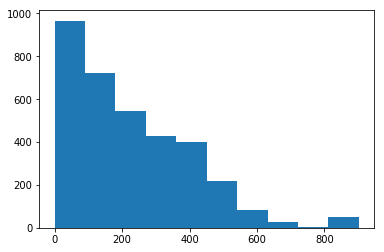

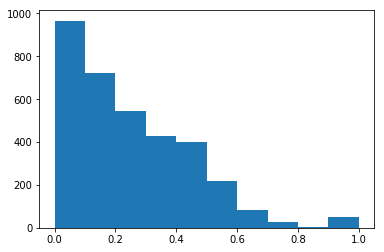

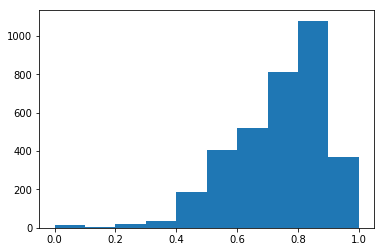

In [36]:
plt.hist(food_df_level3.Energy)
plt.show()
plt.hist(food_df_level3.norm_Energy)
plt.show()
plt.hist(food_df_level3.norm_log_Energy)
plt.show()